In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
# import spectroscopy data
raman_spectra = pd.read_csv('/content/drive/My Drive/BDQM_VIP/RamanSpectra.csv', header=None).to_numpy()            #Spectra
raman_concentrations = pd.read_csv('/content/drive/My Drive/BDQM_VIP/RamanConcentrations.csv', header=None).to_numpy()     #Concentrations
raman_shifts = pd.read_csv('/content/drive/My Drive/BDQM_VIP/RamanShifts.csv', header=None).to_numpy()             #Raman Shifts
Species = ['Kyanite','Wollastonite','Olivine','Silica','Zircon'] # different insoluble GFCs for raman spec.

In [14]:
print(raman_shifts)

[[1700.]
 [1699.]
 [1698.]
 ...
 [ 102.]
 [ 101.]
 [ 100.]]


In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.integrate import simps
import pandas as pd


# Calculate the area under each spectra curve
areas = np.array([simps(spectrum, np.flip(raman_shifts.flatten())) for spectrum in raman_spectra])

# Preparing the dataset
X = areas.reshape(-1, 1)
y = raman_concentrations[:, 0]  # Concentrations of the first compound - Kyanite

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# Create a custom dataset
class RamanDataset(Dataset):
    def __init__(self, areas, concentrations):
        self.areas = areas
        self.concentrations = concentrations

    def __len__(self):
        return len(self.areas)

    def __getitem__(self, idx):
        return self.areas[idx], self.concentrations[idx]

# Load the data into DataLoader
train_dataset = RamanDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = RamanDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class PhysicsInformedNN(nn.Module):
    def __init__(self):
        super(PhysicsInformedNN, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = nn.LeakyReLU(0.2)(self.fc1(x))
        x = nn.LeakyReLU(0.2)(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = PhysicsInformedNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Physics-informed constraint: second derivative should be close to zero
def physics_constraint(output, input_tensor):
    # Calculate second derivative
    first_derivative = torch.autograd.grad(output, input_tensor, grad_outputs=torch.ones_like(output), create_graph=True)[0]
    second_derivative = torch.autograd.grad(first_derivative, input_tensor, grad_outputs=torch.ones_like(first_derivative), create_graph=True)[0]

    # Mean squared error of the second derivative with respect to zero
    return torch.mean(second_derivative ** 2)

# Training loop with physics constraint
num_epochs = 100
for epoch in range(num_epochs):
    for areas, concentrations in train_loader:
        areas.requires_grad = True
        optimizer.zero_grad()

        outputs = model(areas)
        loss = criterion(outputs, concentrations.unsqueeze(1))

        # Apply the physics constraint
        physics_loss = physics_constraint(outputs, areas)
        total_loss = loss + physics_loss

        total_loss.backward()
        optimizer.step()

# Testing and evaluation (code to be added)

# Note: This code assumes a linear relationship between concentration and the area under the spectra, as reflected in the physics constraint.


In [26]:
from sklearn.metrics import mean_squared_error

# Testing and Evaluation
model.eval()  # Set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():  # Disable gradient computation
    for X, y in test_loader:
        output = model(X)
        output = output.view(-1)  # Flatten the output

        # Inverse transform to get predictions in the original scale
        predicted = scaler_y.inverse_transform(output.numpy().reshape(-1, 1)).flatten()
        actual = scaler_y.inverse_transform(y.numpy().reshape(-1, 1)).flatten()

        predictions.extend(predicted)
        actuals.extend(actual)

# Calculating the mean squared error
mse = mean_squared_error(actuals, predictions)

# Output the results
print("Mean Squared Error:", mse)
print("Predictions:", predictions)
print("Actual Values:", actuals)


Mean Squared Error: 468.91605
Predictions: [37.014004, 63.77297, 12.429888, 49.860462, 18.991098, 53.10872, 55.319572, 49.68364, 75.38922, 46.036663, 53.265564, 44.97112, 50.59761, 38.9278]
Actual Values: [71.75889, 87.20961, 5.8602085, 62.11135, 12.24991, 92.754974, 28.91283, 21.793678, 99.60901, 46.062878, 50.354496, 18.558836, 56.15158, 24.816336]


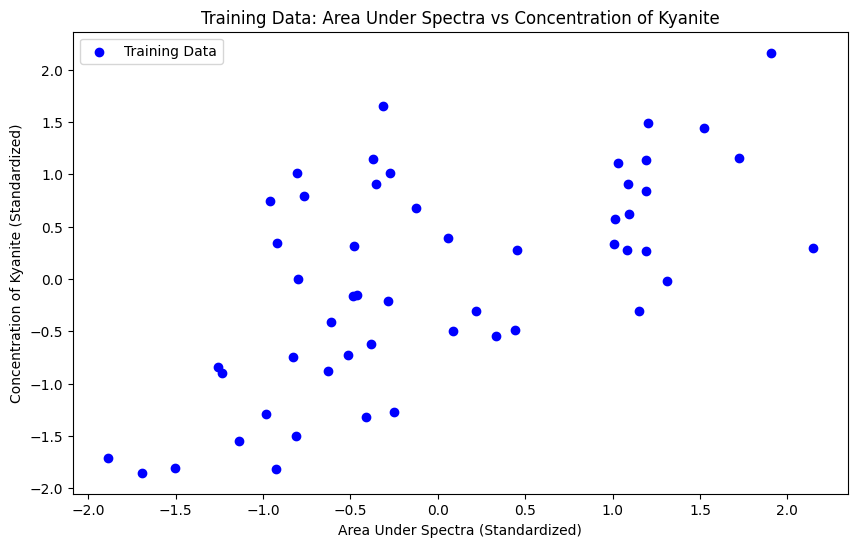

In [27]:
import matplotlib.pyplot as plt

# Plotting X_train vs y_train
plt.figure(figsize=(10, 6))
plt.scatter(X_train.flatten(), y_train, color='blue', label='Training Data')
plt.xlabel('Area Under Spectra (Standardized)')
plt.ylabel('Concentration of Kyanite (Standardized)')
plt.title('Training Data: Area Under Spectra vs Concentration of Kyanite')
plt.legend()
plt.show()

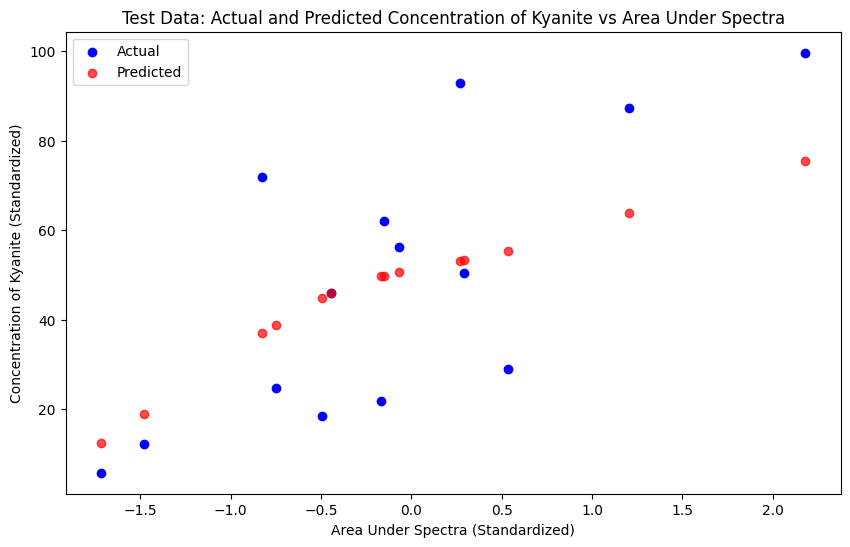

In [28]:
import matplotlib.pyplot as plt

# Plotting X_test vs Actual and Predicted values
plt.figure(figsize=(10, 6))

# Actual values
plt.scatter(X_test.flatten(), actuals, color='blue', label='Actual')

# Predicted values
plt.scatter(X_test.flatten(), predictions, color='red', label='Predicted', alpha=0.7)

plt.xlabel('Area Under Spectra (Standardized)')
plt.ylabel('Concentration of Kyanite (Standardized)')
plt.title('Test Data: Actual and Predicted Concentration of Kyanite vs Area Under Spectra')
plt.legend()
plt.show()
